In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
import itertools

from tqdm import tqdm
import os
import cv2
import numpy as np

import tensorflow as tf
from tensorflow import keras
from keras import losses
from keras import layers, Sequential
from keras.applications import VGG16, VGG19, ResNet101

from matplotlib import pyplot as plt
from sklearn.metrics import classification_report

In [3]:
CLASS_NAMES = ['sehat', 'giberella', 'anthracnose']

def load_data(path):

    images = []
    labels = []

    print("Loading {}".format(path))

    # Iterate through each folder corresponding to a category
    for i, folder in enumerate(CLASS_NAMES):
        label = i
        for file in tqdm(os.listdir(os.path.join(path, folder))):

            # Get the path name of the image
            img_path = os.path.join(os.path.join(path, folder), file)

            # Open and resize the img
            image = cv2.imread(img_path, 1)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (224, 224))

            # Append the image and its corresponding label to the output
            images.append(image)
            labels.append(label)

    images = tf.convert_to_tensor(images, dtype=tf.uint8)
    labels = tf.convert_to_tensor(labels, dtype=tf.uint8)

    return (images, labels)

In [4]:
def show_sample_images(data, n_images):

    images, labels = data

    fig, axs = plt.subplots(nrows=n_images, ncols=len(CLASS_NAMES), figsize=(9, 10),
                            subplot_kw={'xticks': [], 'yticks': []})

    for col in range(len(CLASS_NAMES)):
        sample = images[labels==col][:n_images]
        for row in range(n_images):
            axs[row][col].imshow(sample[row])
            axs[row][col].set_title(CLASS_NAMES[col])

    plt.tight_layout()
    plt.show()

In [5]:
def plot_distribution_data(train_data, val_data, test_data):
    amount = {
        'Train': [ 0 for _ in range(len(np.unique(train_data))) ],
        'Val': [ 0 for _ in range(len(np.unique(train_data))) ],
        'Test': [ 0 for _ in range(len(np.unique(train_data))) ],
    }

    # count amount of data train
    for clas in train_data:
        amount['Train'][clas] += 1

    # count amount of data val
    for clas in val_data:
        amount['Val'][clas] += 1

    # count amount of data test
    for clas in test_data:
        amount['Test'][clas] += 1

    x = np.arange(len(CLASS_NAMES))  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained')

    for attribute, measurement in amount.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute)
        ax.bar_label(rects, padding=3)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Total')
    ax.set_title('Data distribution by classes')
    ax.set_xticks(x + width, CLASS_NAMES)
    ax.legend(loc='upper left', ncols=3)
    ax.set_ylim(0, 100)

    plt.show()

In [6]:
def plot_history(history):
    fig, axs = plt.subplots(2, 1, figsize=(10,10))

    axs[0].plot(history['loss'])
    axs[0].plot(history['val_loss'])
    axs[0].title.set_text('Training Loss vs Validation Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend(['Train','Val'])

    axs[1].plot(history['accuracy'])
    axs[1].plot(history['val_accuracy'])
    axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_ylim(0, 1)
    axs[1].legend(['Train', 'Val'])

In [7]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Data original

In [8]:
X_train, y_train = load_data("/content/drive/MyDrive/klasifikasi-daun-jagung/dataset/original/train")
X_train = X_train / 255

X_val, y_val = load_data("/content/drive/MyDrive/klasifikasi-daun-jagung/dataset/original/val")
X_val = X_val / 255

X_test, y_test = load_data("/content/drive/MyDrive/klasifikasi-daun-jagung/dataset/original/test")
X_test = X_test / 255

Loading /content/drive/MyDrive/klasifikasi-daun-jagung/dataset/original/train


100%|██████████| 64/64 [00:57<00:00,  1.11it/s]


Loading /content/drive/MyDrive/klasifikasi-daun-jagung/dataset/original/val


100%|██████████| 16/16 [00:14<00:00,  1.12it/s]


Loading /content/drive/MyDrive/klasifikasi-daun-jagung/dataset/original/test


100%|██████████| 20/20 [00:16<00:00,  1.22it/s]


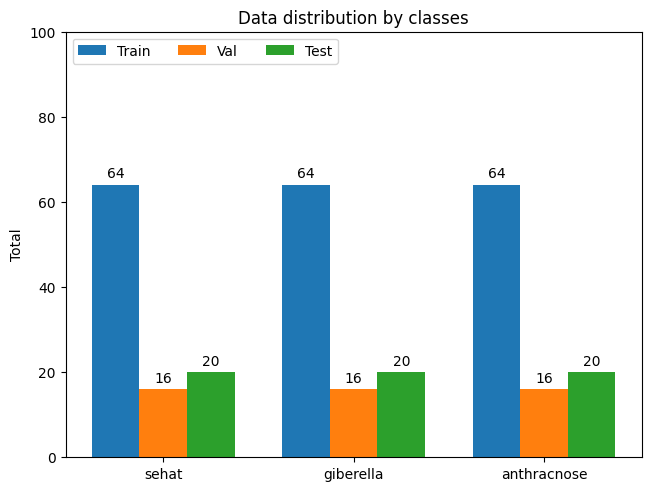

In [9]:
plot_distribution_data(y_train, y_val, y_test)

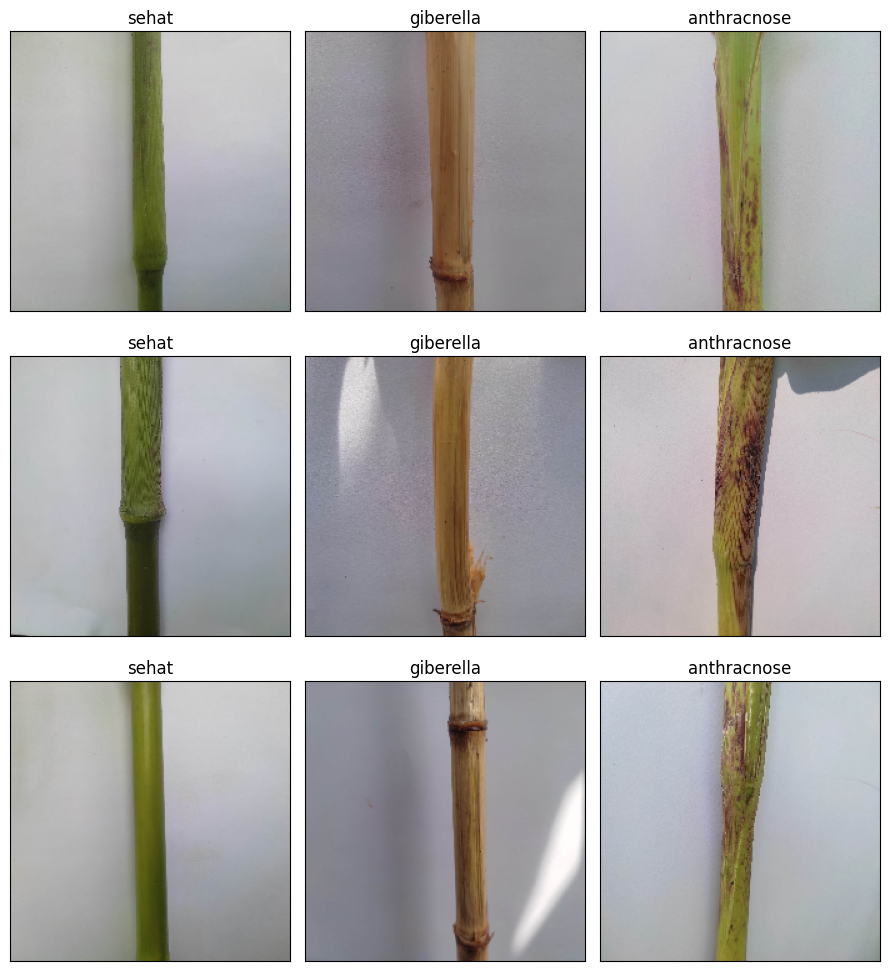

In [10]:
show_sample_images(data=(X_train, y_train), n_images=3)

## VGG16

In [ ]:
model = tf.keras.applications.VGG16(
    include_top=True,
    weights=None,
    classes=3,
    classifier_activation='softmax'
)

### SGD optimizer

In [ ]:
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.0001),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='vgg16-original-sgd.weights.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=50,
    callbacks=[cp_callback]
)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.3730 - loss: 1.0985
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to vgg16-original-sgd.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.3673 - loss: 1.0985 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.3405 - loss: 1.0986
Epoch 2: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 576ms/step - accuracy: 0.3394 - loss: 1.0986 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.3352 - loss: 1.0986
Epoch 3: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 574ms/step - accuracy: 0.3350 - loss: 1.0986 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.3366 - loss: 1.0986
Epoch 4: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 565ms/step - accuracy: 0.3362 - loss: 1.

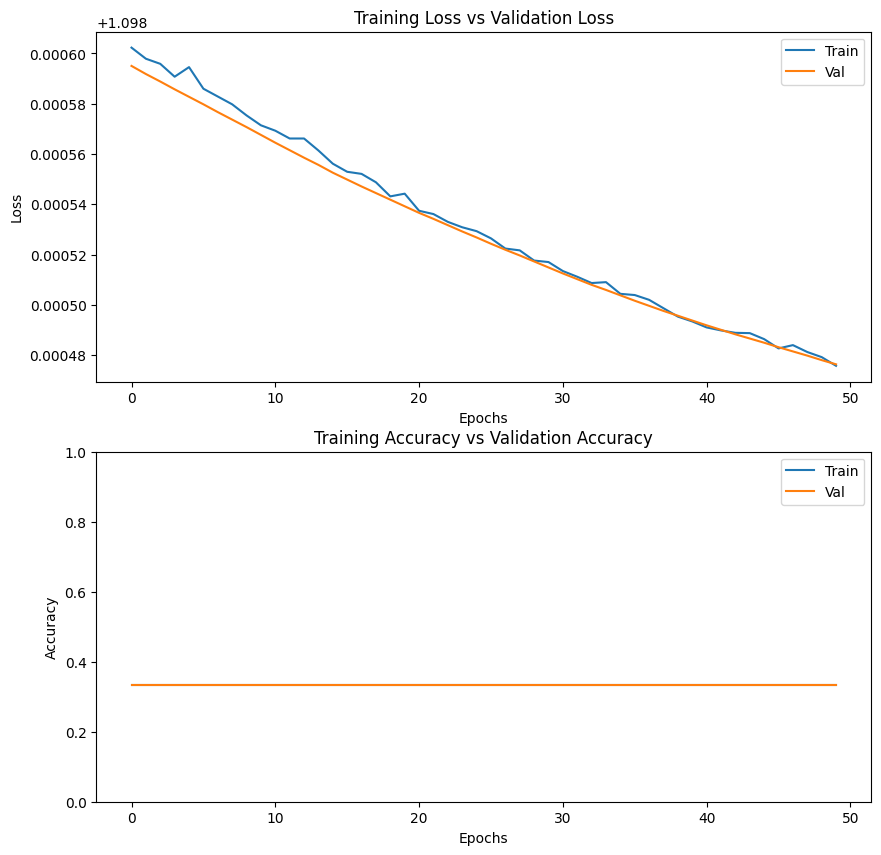

In [ ]:
plot_history(history.history)

2/2 ━━━━━━━━━━━━━━━━━━━━ 25s 12s/step


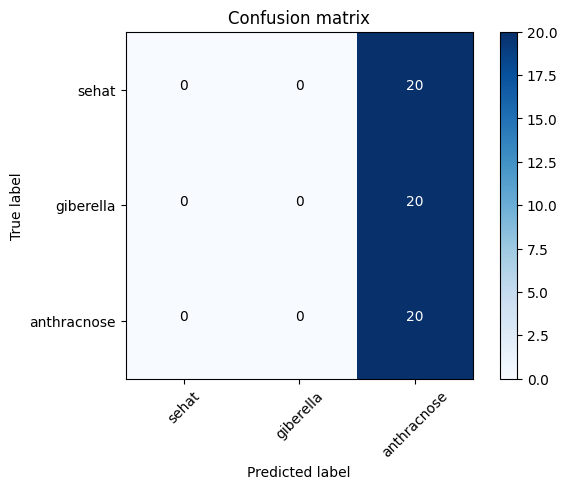

In [41]:
model.load_weights('vgg16-original-sgd.weights.h5')

y_pred = model.predict(X_test)
y_pred = tf.math.argmax(y_pred, axis=1)

cm_data = tf.math.confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm_data.numpy(), CLASS_NAMES)


In [43]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.00      0.00      0.00        20
           2       0.33      1.00      0.50        20

    accuracy                           0.33        60
   macro avg       0.11      0.33      0.17        60
weighted avg       0.11      0.33      0.17        60



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
!cp vgg16-original-sgd.weights.h5 /content/drive/MyDrive/klasifikasi-daun-jagung/model-weights

### RMSprop optimizer

In [45]:
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.0001),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='vgg16-original-rmsprop.weights.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=50,
    callbacks=[cp_callback]
)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.2626 - loss: 1.0997
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to vgg16-original-rmsprop.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 87s 16s/step - accuracy: 0.2638 - loss: 1.0997 - val_accuracy: 0.3333 - val_loss: 1.0985
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.3559 - loss: 1.0982
Epoch 2: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 61s 538ms/step - accuracy: 0.3527 - loss: 1.0983 - val_accuracy: 0.3333 - val_loss: 1.0984
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.3210 - loss: 1.0987
Epoch 3: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 541ms/step - accuracy: 0.3176 - loss: 1.0987 - val_accuracy: 0.3333 - val_loss: 1.0982
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.3122 - loss: 1.0986
Epoch 4: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 554ms/step - accuracy: 0.3145 - los

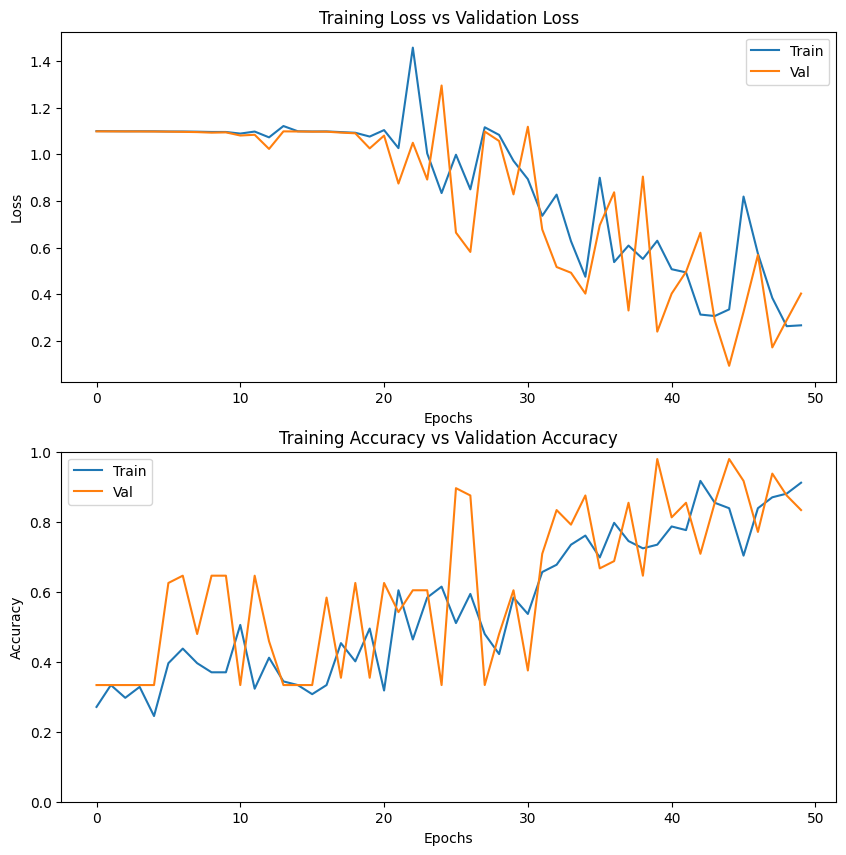

In [46]:
plot_history(history.history)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


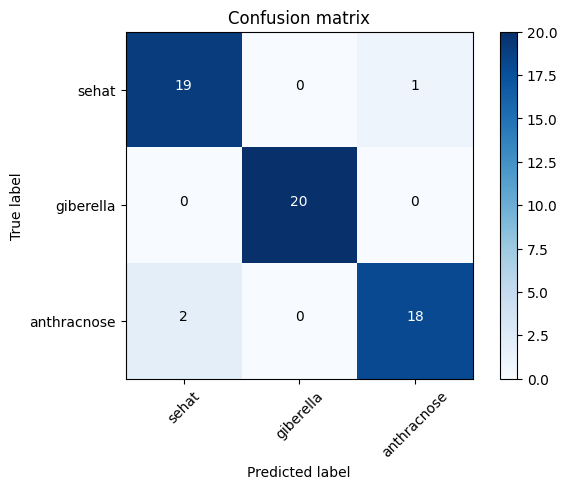

In [47]:
model.load_weights('vgg16-original-rmsprop.weights.h5')

y_pred = model.predict(X_test)
y_pred = tf.math.argmax(y_pred, axis=1)

cm_data = tf.math.confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm_data.numpy(), CLASS_NAMES)


In [48]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.95      0.93        20
           1       1.00      1.00      1.00        20
           2       0.95      0.90      0.92        20

    accuracy                           0.95        60
   macro avg       0.95      0.95      0.95        60
weighted avg       0.95      0.95      0.95        60



In [49]:
!cp vgg16-original-rmsprop.weights.h5 /content/drive/MyDrive/klasifikasi-daun-jagung/model-weights

### Adam optimizer

In [50]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='vgg16-original-adam.weights.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=50,
    callbacks=[cp_callback]
)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.8968 - loss: 0.4360
Epoch 1: val_accuracy improved from -inf to 0.89583, saving model to vgg16-original-adam.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 150s 28s/step - accuracy: 0.8892 - loss: 0.4507 - val_accuracy: 0.8958 - val_loss: 0.2585
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.9392 - loss: 0.2415
Epoch 2: val_accuracy did not improve from 0.89583
6/6 ━━━━━━━━━━━━━━━━━━━━ 61s 569ms/step - accuracy: 0.9360 - loss: 0.2452 - val_accuracy: 0.7708 - val_loss: 0.3634
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.9537 - loss: 0.2099
Epoch 3: val_accuracy did not improve from 0.89583
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 575ms/step - accuracy: 0.9536 - loss: 0.2094 - val_accuracy: 0.8750 - val_loss: 0.3352
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.9224 - loss: 0.1513
Epoch 4: val_accuracy did not improve from 0.89583
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 586ms/step - accuracy: 0.9238 - loss:

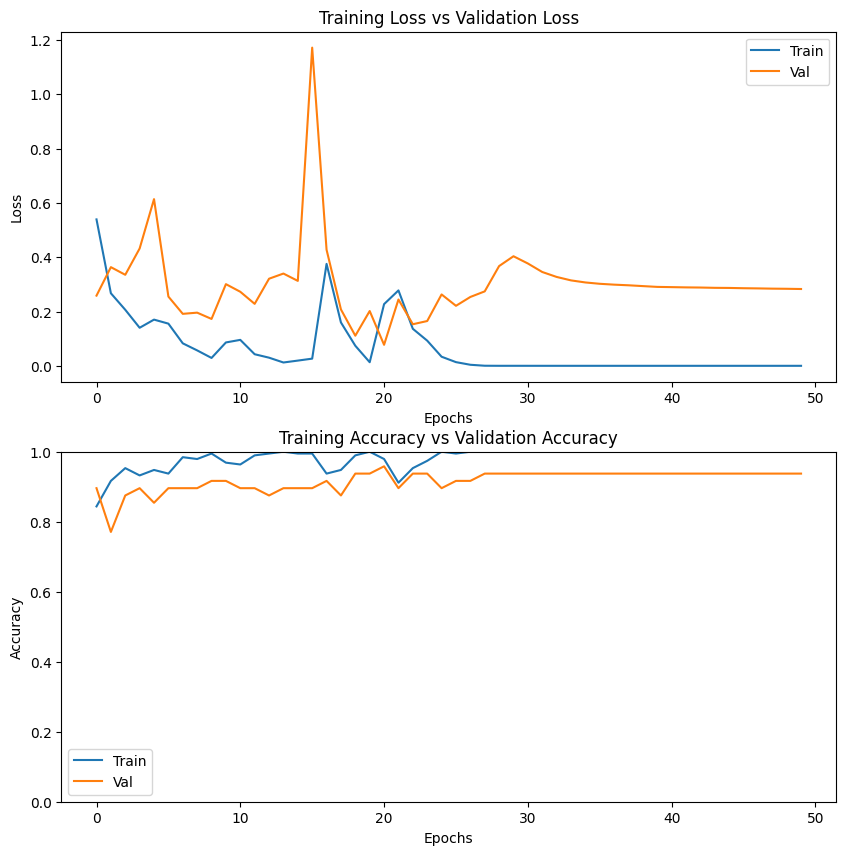

In [54]:
plot_history(history.history)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 940ms/step


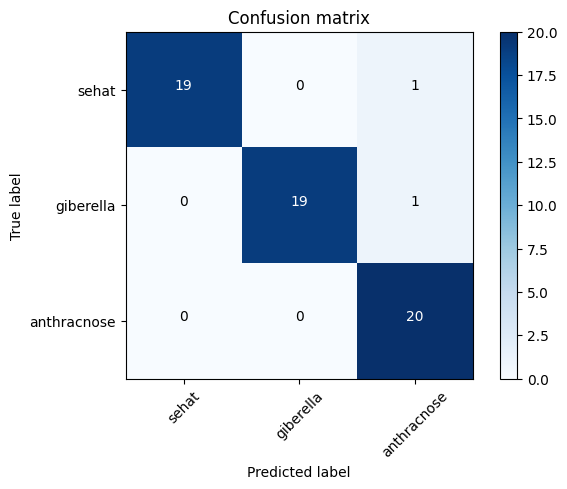

In [51]:
model.load_weights('vgg16-original-adam.weights.h5')

y_pred = model.predict(X_test)
y_pred = tf.math.argmax(y_pred, axis=1)

cm_data = tf.math.confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm_data.numpy(), CLASS_NAMES)


In [52]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97        20
           1       1.00      0.95      0.97        20
           2       0.91      1.00      0.95        20

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



In [53]:
!cp vgg16-original-adam.weights.h5 /content/drive/MyDrive/klasifikasi-daun-jagung/model-weights

## VGG19

### SGD optimizer

In [ ]:
model = VGG19(
    include_top=True,
    weights=None,
    classes=3,
    classifier_activation='softmax'
)

model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.0001),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

In [ ]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='vgg19-original-sgd.weights.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=50,
    callbacks=[cp_callback]
)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.3778 - loss: 1.0986
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to vgg19-original-sgd.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.3714 - loss: 1.0986 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 595ms/step - accuracy: 0.3339 - loss: 1.0986
Epoch 2: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 646ms/step - accuracy: 0.3338 - loss: 1.0986 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - accuracy: 0.3420 - loss: 1.0986
Epoch 3: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 656ms/step - accuracy: 0.3408 - loss: 1.0986 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.3087 - loss: 1.0986
Epoch 4: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 662ms/step - accuracy: 0.3122 - loss: 1.

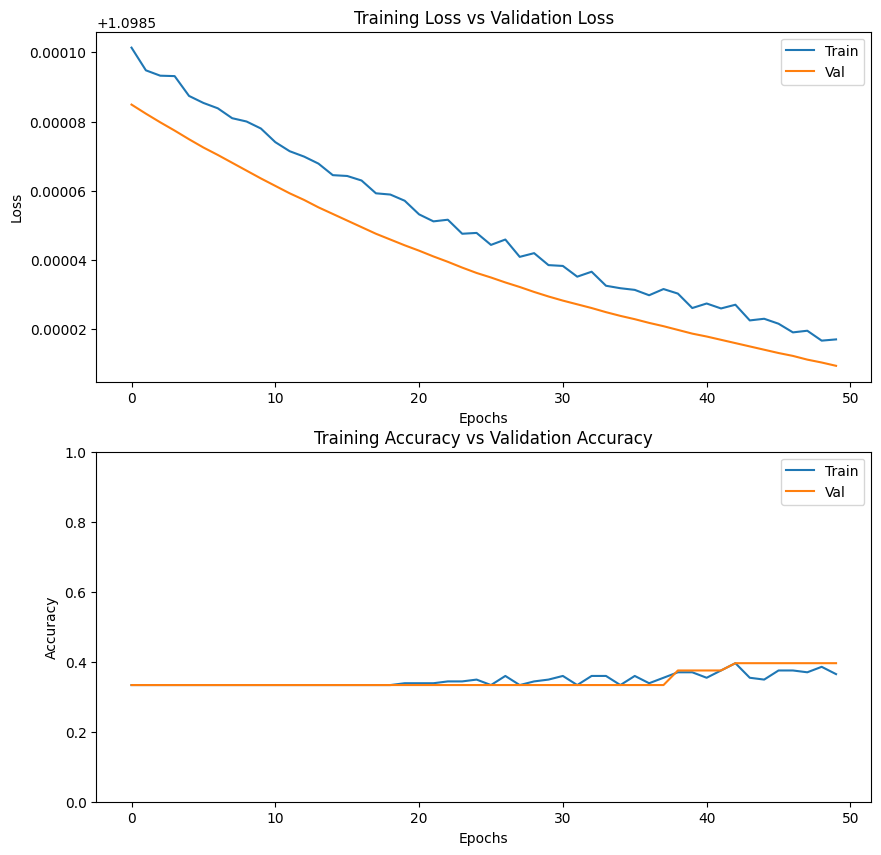

In [ ]:
plot_history(history.history)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step


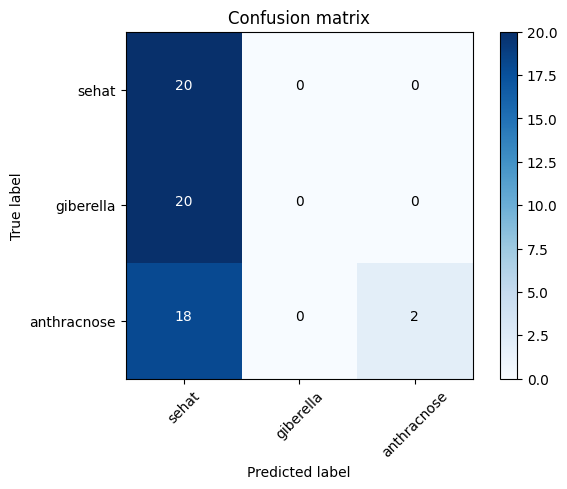

In [ ]:
model.load_weights('vgg19-original-sgd.weights.h5')

y_pred = model.predict(X_test)
y_pred = tf.math.argmax(y_pred, axis=1)

cm_data = tf.math.confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm_data.numpy(), CLASS_NAMES)

In [ ]:
!cp vgg19-original-sgd.weights.h5 /content/drive/MyDrive/klasifikasi-daun-jagung/model-weights

## AlexNet

## ResNet101

In [14]:
model = ResNet101(
    include_top=True,
    weights=None,
    classes=3,
    classifier_activation='softmax'
)

### SGD optimizer

In [15]:
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.0001),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='resnet101-original-sgd.weights.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=50,
    callbacks=[cp_callback]
)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - accuracy: 0.3001 - loss: 1.9257
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to resnet101-original-sgd.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 70s 4s/step - accuracy: 0.3056 - loss: 1.8928 - val_accuracy: 0.3333 - val_loss: 1.1006
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.3244 - loss: 1.4545
Epoch 2: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 41s 546ms/step - accuracy: 0.3249 - loss: 1.4503 - val_accuracy: 0.3333 - val_loss: 1.1034
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.2826 - loss: 1.3455
Epoch 3: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 564ms/step - accuracy: 0.2854 - loss: 1.3388 - val_accuracy: 0.3333 - val_loss: 1.1078
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.2651 - loss: 1.2456
Epoch 4: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 559ms/step - accuracy: 0.2682 - loss

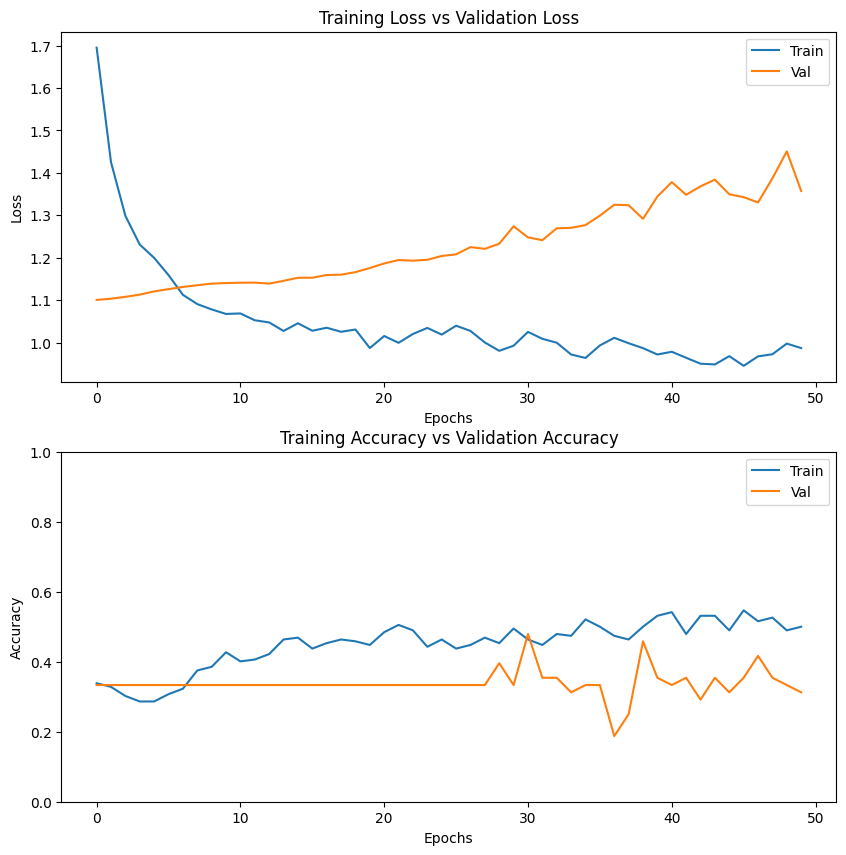

In [16]:
plot_history(history.history)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 838 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


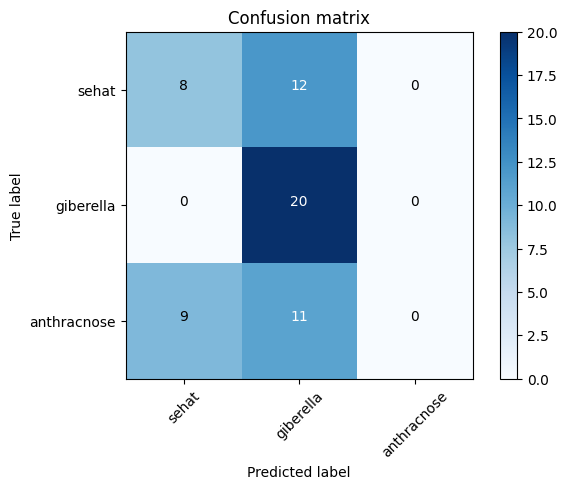

In [33]:
model.load_weights('resnet101-original-sgd.weights.h5')

y_pred = model.predict(X_test)
y_pred = tf.math.argmax(y_pred, axis=1)

cm_data = tf.math.confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm_data.numpy(), CLASS_NAMES)

In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.47      0.40      0.43        20
           1       0.47      1.00      0.63        20
           2       0.00      0.00      0.00        20

    accuracy                           0.47        60
   macro avg       0.31      0.47      0.36        60
weighted avg       0.31      0.47      0.36        60



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [18]:
!cp resnet101-original-sgd.weights.h5 /content/drive/MyDrive/klasifikasi-daun-jagung/model-weights

### RMSPROP

In [20]:
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.0001),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='resnet101-original-rmsprop.weights.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=50,
    callbacks=[cp_callback]
)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.4339 - loss: 1.3168
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to resnet101-original-rmsprop.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 96s 5s/step - accuracy: 0.4359 - loss: 1.3139 - val_accuracy: 0.3333 - val_loss: 1.3762
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.7056 - loss: 0.6751
Epoch 2: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 687ms/step - accuracy: 0.7112 - loss: 0.6675 - val_accuracy: 0.3333 - val_loss: 2.1651
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - accuracy: 0.8451 - loss: 0.4438
Epoch 3: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 573ms/step - accuracy: 0.8420 - loss: 0.4463 - val_accuracy: 0.3333 - val_loss: 3.1875
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.9112 - loss: 0.3393
Epoch 4: val_accuracy did not improve from 0.33333
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 611ms/step - accuracy: 0.9090 - l

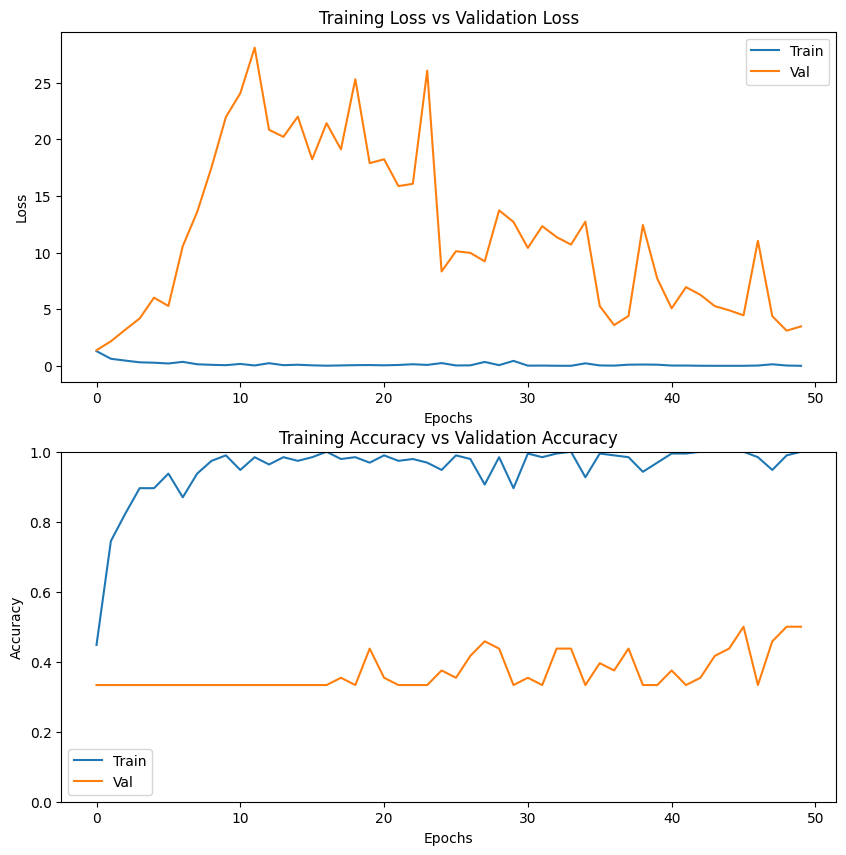

In [21]:
plot_history(history.history)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 838 variables whereas the saved optimizer has 420 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


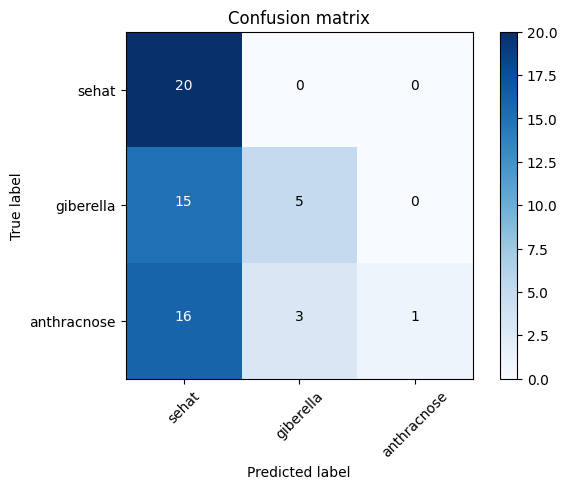

In [31]:
model.load_weights('resnet101-original-rmsprop.weights.h5')

y_pred = model.predict(X_test)
y_pred = tf.math.argmax(y_pred, axis=1)

cm_data = tf.math.confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm_data.numpy(), CLASS_NAMES)

In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.39      1.00      0.56        20
           1       0.62      0.25      0.36        20
           2       1.00      0.05      0.10        20

    accuracy                           0.43        60
   macro avg       0.67      0.43      0.34        60
weighted avg       0.67      0.43      0.34        60



In [24]:
!cp resnet101-original-rmsprop.weights.h5 /content/drive/MyDrive/klasifikasi-daun-jagung/model-weights

### Adam

In [25]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='resnet101-original-adam.weights.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=50,
    callbacks=[cp_callback]
)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 1.0000 - loss: 0.0015
Epoch 1: val_accuracy improved from -inf to 0.41667, saving model to resnet101-original-adam.weights.h5
6/6 ━━━━━━━━━━━━━━━━━━━━ 128s 4s/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.4167 - val_loss: 7.2742
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.9701 - loss: 0.0846
Epoch 2: val_accuracy did not improve from 0.41667
6/6 ━━━━━━━━━━━━━━━━━━━━ 33s 592ms/step - accuracy: 0.9706 - loss: 0.0837 - val_accuracy: 0.3333 - val_loss: 13.0025
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - accuracy: 0.9434 - loss: 0.3308
Epoch 3: val_accuracy did not improve from 0.41667
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 609ms/step - accuracy: 0.9463 - loss: 0.3092 - val_accuracy: 0.3750 - val_loss: 14.9684
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.9705 - loss: 0.0611
Epoch 4: val_accuracy did not improve from 0.41667
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 615ms/step - accuracy: 0.9710 - 

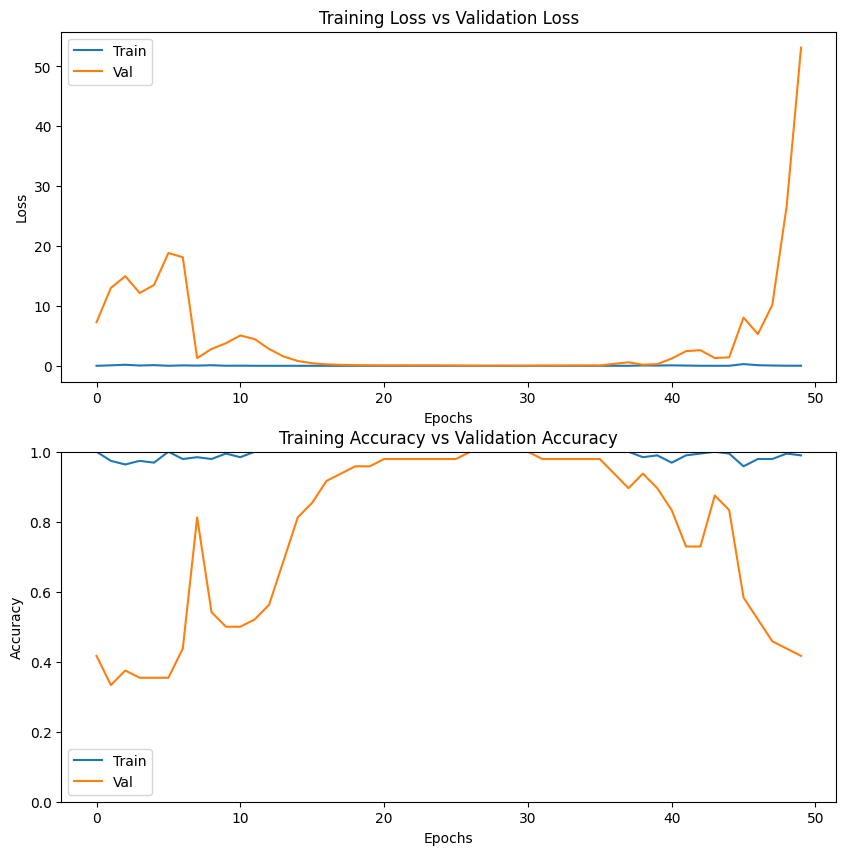

In [27]:
plot_history(history.history)

1/2 ━━━━━━━━━━━━━━━━━━━━ 10s 11s/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 8s/step


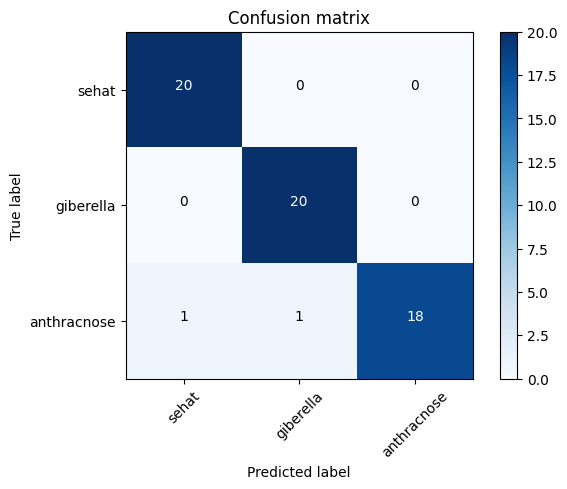

In [28]:
model.load_weights('resnet101-original-adam.weights.h5')

y_pred = model.predict(X_test)
y_pred = tf.math.argmax(y_pred, axis=1)

cm_data = tf.math.confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm_data.numpy(), CLASS_NAMES)

In [30]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       0.95      1.00      0.98        20
           2       1.00      0.90      0.95        20

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



In [26]:
!cp resnet101-original-adam.weights.h5 /content/drive/MyDrive/klasifikasi-daun-jagung/model-weights

# Data CLAHE

In [ ]:
#